In [1]:
using OpenQuantumTools
using LinearAlgebra
using OpenQuantumBase
using QuantumOptics
using OrdinaryDiffEq
using AVQD
using Plots
using CollectiveSpins
using QuantumOptics
# using PyPlot
using VarStructs
using Logging
using Suppressor
using LinearAlgebra
using JLD2
using LaTeXStrings
using CSV

In [7]:
@var struct Spin_obj_template
    no_spins::Int64
    no_exc::Int64
    spin_type::Union{Int64,Float64}
    transition_omega::Union{Int64,Float64}
    geom_type::String
    lat_const::Union{Int64,Float64}   # in units of (transition omega)^-1 i.e. proportional to (c*k_0)^-1
end


function spin_object_constructor(no_spins::Int64, no_exc::Int64, spin_type::Union{Int64,Float64},
    transition_omega::Union{Int64,Float64}, geom_type::String, lat_const::Union{Int64,Float64})::Spin_obj_template

    N = no_spins
    full_exc = "True"

    if (full_exc == "True")
        M = N # Number of excitations 
    else
        M = no_exc
    end

    S = spin_type
    d_by_k0 = lat_const
    geom_type = geom_type

    Spin_obj = Spin_obj_template(no_spins=N, no_exc=M, spin_type=S,
        transition_omega=transition_omega,
        geom_type=geom_type, lat_const=d_by_k0)

    #println(N,M,d_by_k0)
    Spin_obj = Lattice_constructor(Spin_obj)
    return Spin_obj
end

function Lattice_constructor(Spin_obj::Spin_obj_template)::Spin_obj_template
    N = Spin_obj.no_spins
    M = Spin_obj.no_exc # Number of excitations
    d = Spin_obj.lat_const
    #println(N,M,d)
    #pos = geometry.chain(d,N)
    if Spin_obj.geom_type == "square"
        Spin_obj.pos_array = geometry.square(d; Nx=Int(sqrt(N)), Ny=Int(sqrt(N)))
    elseif Spin_obj.geom_type == "chain"
        Spin_obj.pos_array = geometry.chain(d, N)
    elseif Spin_obj.geom_type == "rectangle"
        println("Enter no_spins along x ")
        Nx = Int(readlines())
        #Nx = 2
        println("Enter no_spins along y ")
        Ny = Int(readlines())
        #Ny = 3
        d_1 = d
        d_2 = 2.0d
        Spin_obj.pos_array = geometry.rectangle(d_1, d_2; Nx=Int(Nx), Ny=Int(Ny))
    end
    Spin_obj.mu = [[1.0, 0, 0] for i = 1:N]   # lattice polarization
    Spin_obj.collection = SpinCollection(Spin_obj.pos_array, Spin_obj.mu)   # lattice positions
    Spin_obj.Omega_mat = OmegaMatrix(Spin_obj.collection)
    Spin_obj.Gamma_mat = GammaMatrix(Spin_obj.collection)
    # Hilbert space
    Spin_obj.basis_atom = SpinBasis(Spin_obj.spin_type) # Basis up to M excitations
    return Spin_obj
end

function spin_collection_op(Spin_obj::Spin_obj_template, i::Int64)::Vector{Operator}
    N = Spin_obj.no_spins
    Spin_obj.basis_ensemble = tensor([Spin_obj.basis_atom for m = 1:N]...)
    sm = embed(Spin_obj.basis_ensemble, i, sigmam(Spin_obj.basis_atom))
    sp = embed(Spin_obj.basis_ensemble, i, sigmap(Spin_obj.basis_atom))
    sz = embed(Spin_obj.basis_ensemble, i, sigmaz(Spin_obj.basis_atom))
    return [sm, sp, sz]
end

function Ham_and_state_constructor(Spin_obj::Spin_obj_template)::Spin_obj_template
    N = Spin_obj.no_spins
    M = Spin_obj.no_exc # Number of excitations
    d = Spin_obj.lat_const

    Operator_sm_array = []
    Operator_sp_array = []
    Operator_sz_array = []
    #sigma_p_sigma_m = [reducedsigmapsigmam(basis, i, j) for i=1:N, j=1:N]
    for i in 1:N
        temp_op = spin_collection_op(Spin_obj, i)
        push!(Operator_sm_array, temp_op[1])
        push!(Operator_sp_array, temp_op[2])
        push!(Operator_sz_array, temp_op[3])
    end

    Spin_obj.H_eff = sum((Spin_obj.Omega_mat[i, j]) * (Operator_sp_array[i] * Operator_sm_array[j]) for i = 1:N, j = 1:N) +
                     sum((Spin_obj.transition_omega) * (Operator_sp_array[i] * Operator_sm_array[i]) for i = 1:N)

    return Spin_obj
end


function diagonal_jump_operators(Spin_obj::Spin_obj_template)::Spin_obj_template
    N = Spin_obj.no_spins
    M = Spin_obj.no_exc # Number of excitations
    d = Spin_obj.lat_const
    sigma_i_m_op = [spin_collection_op(Spin_obj, i)[1] for i = 1:N]
    temp_ops = diagonaljumps(Spin_obj.Gamma_mat, sigma_i_m_op)
    Spin_obj.gamma_diag, Spin_obj.J_diag = temp_ops[1], temp_ops[2]
    return Spin_obj
end



function op_vs_t(Spin_obj::Spin_obj_template, rho)::Tuple{Vector{Float64},Vector{Float64},Vector{Float64},Vector{Float64}}
    N = Spin_obj.no_spins
    #basis = ReducedSpinBasis(no_spins,no_exc) # Basis up to M excitations
    Operator_sz_array = []
    #Operator_sm_array = []
    #Operator_sp_array = []
    for i in 1:N
        temp_op = spin_collection_op(Spin_obj, i)
        #push!(Operator_sm_array, temp_op[1])
        #push!(Operator_sp_array,temp_op[2])
        push!(Operator_sz_array, temp_op[3])
    end
    prop_z_avg = real(expect(sum([Operator_sz_array[i] for i = 1:N]), rho))

    prop_g2 = real(expect(sum((Spin_obj.gamma_diag[i] * Spin_obj.gamma_diag[j]) *
                              (dagger(Spin_obj.J_diag[i]) * dagger(Spin_obj.J_diag[j]) * Spin_obj.J_diag[j] * Spin_obj.J_diag[i]) for i = 1:N, j = 1:N), rho)) ./
              (real(expect(sum((Spin_obj.gamma_diag[i]) * (dagger(Spin_obj.J_diag[i]) * Spin_obj.J_diag[i]) for i = 1:N), rho))) .^ 2

    prop_emiss = real(expect(sum((Spin_obj.gamma_diag[i]) * (dagger(Spin_obj.J_diag[i]) * Spin_obj.J_diag[i]) for i = 1:N), rho))
    prop_Pop_ee = real(expect(sum([spin_collection_op(Spin_obj, i)[2] * spin_collection_op(Spin_obj, i)[1] for i in 1:N]), rho))

    prop_gamma_instant = prop_emiss ./ prop_Pop_ee
    #prop_gamma_instant = prop_Pop_ee
    #println(prop_g2)
    return prop_z_avg, prop_emiss, prop_g2, prop_gamma_instant
end


function time_evolution_master(Spin_obj::Spin_obj_template, time_list::Vector{Float64}, initial_state::Ket,
    type_of_evol::String)

    #::Tuple{Vector{Float64}, Union{Vector{Ket},Vector{Operator}},
    # Vector{Float64}, Vector{Float64}, Vector{Float64}}

    if type_of_evol == "master_eqn"
        time_list_out, rho = @suppress timeevolution.master(time_list, initial_state, Spin_obj.H_eff, Spin_obj.J_diag;
            rates=Spin_obj.gamma_diag)
        prop_z_avg, prop_emiss, prop_g2, prop_gamma_instant = op_vs_t(Spin_obj, rho)
        return time_list_out, rho, prop_z_avg, prop_emiss, prop_g2, prop_gamma_instant

    elseif type_of_evol == "MCWF"
        time_list_out, state = @suppress timeevolution.mcwf(time_list, initial_state, Spin_obj.H_eff, Spin_obj.J_diag;
            rates=Spin_obj.gamma_diag)
        prop_z_avg, prop_emiss, prop_g2, prop_gamma_instant = op_vs_t(Spin_obj, state)
        return time_list_out, state
    end
end


time_evolution_master (generic function with 1 method)

3000

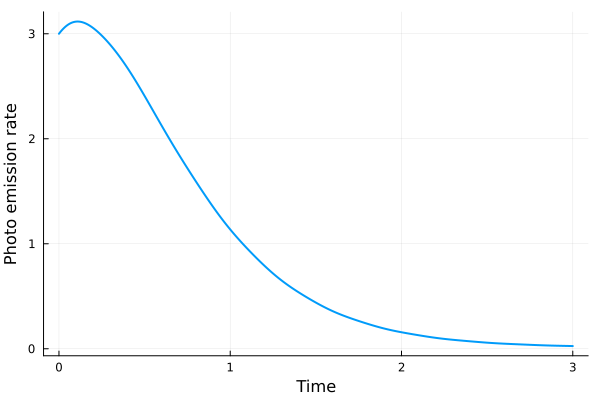

In [43]:
No_spins = 3
N = No_spins
No_exc = No_spins
spin_type = 1 / 2
spin_geom = "chain"
lat_const = 0.1
transition_omega = 2 * pi
Spin_system_object = spin_object_constructor(No_spins, No_exc, spin_type, transition_omega, spin_geom, lat_const);   #M is now disregarded
Spin_system_object = Ham_and_state_constructor(Spin_system_object)
Spin_system_object = diagonal_jump_operators(Spin_system_object)

H = Matrix(Spin_system_object.H_eff.data)

tf = 3.0
dt = 0.001
u0 = zeros(ComplexF64, 2^N, 2^N) #[1.0+0im 0 0 0;0 0 0 0; 0 0 0 0; 0 0 0 0]
u0[1, 1] = 1.0 + 0im

H = Hamiltonian([(s) -> 1.0], [H], unit=:ħ)

Gamma = Matrix(Spin_system_object.Gamma_mat)
γ = Spin_system_object.gamma_diag
L = [Matrix(Spin_system_object.J_diag[i].data) for i in 1:N]
linds = [Lindblad(γ[i], L[i]) for i in 1:N]
linds = InteractionSet(linds...)

annealing = Annealing(H, u0, interactions=linds)
sol = solve_lindblad(annealing, tf, alg=Tsit5(), abstol=1e-6, reltol=1e-6, saveat=0:dt:tf)
# jldsave("dicke_exact_0.1.jld2"; sol.u)

steps=Integer(tf/dt)
excited=[Float64(real(sol.u[i][1])) for i in 1:steps]
# ground=[Float64(real(sol.u[i][2^(2N)])) for i in 1:steps]

# times = LinRange(0, tf, steps)
# Plots.plot(times, excited, label="Excited State", xlabel="Time(s)", ylabel="Amplitude", linewidth=2)
# plot!(times, ground, label="Ground State", linewidth=2)

steps = Integer(tf / dt)

Spin_obj = Spin_system_object
rho = sol.u
prop_emiss = zeros(Float64, steps)
prop_Pop_ee = zeros(Float64, steps)

for j in 1:steps
    prop_emiss[j] = real(tr(sum((Spin_obj.gamma_diag[i]) * (dagger(Spin_obj.J_diag[i]) * Spin_obj.J_diag[i]) for i = 1:N).data * sol.u[j]))
    prop_Pop_ee[j] = real(tr(sum([spin_collection_op(Spin_obj, i)[2] * spin_collection_op(Spin_obj, i)[1] for i in 1:N]).data * sol.u[j]))
end

prop_gamma_instant = prop_emiss #./ prop_Pop_ee
print(steps)
excited = [prop_gamma_instant[i] for i in 1:steps]
times = LinRange(0, tf, steps)
Plots.plot(times, excited, label="", xlabel="Time", ylabel="Photo emission rate", linewidth=2)

## Vectorized

In [36]:
function hereone_step!(A::Ansatz{true}, He, Ha, dt, t)
    relrcut = A.relrcut
    ψ = A |> AVQD.get_state
    dψ = AVQD.partial_theta(A)
    M = AVQD.build_m(ψ, dψ)
    V = AVQD.build_v(ψ, dψ, He, Ha)
    # print("\n M:",M)
    # print("\n V:",V)


    dθ, vmv = AVQD.lin_solve(M, V)
    # print("\n dθ:",dθ)
    # print("\n vmv:",vmv)
    #vmv = V' * inverse(M) * V
    #bound = 2 * real(ψ' * Ha * Ha * ψ + (ψ' * Ha * ψ)^2) #
    #cross = 2 * imag(ψ' * (He * Ha - Ha * He) * ψ)
    #varHe = 2 * real(ψ' * He * He * ψ - (ψ' * He * ψ)^2)

    vmvMax = vmv
    Mtmp = M
    Vtmp = V
    dθtmp = dθ
    opTmp = nothing
    dψₐTmp = nothing

    add_flag = true

    while add_flag
        tagTmp = nothing
        for op in A.pool
            if (AVQD.get_newest_A(A) |> AVQD.tag) == AVQD.tag(op)
                continue
            end
            dψₐ = -0.5im * AVQD.lmul(op, ψ)
            Mop = AVQD.update_m(M, dψₐ, ψ, dψ)
            Vop = AVQD.update_v(V, dψₐ, ψ, He, Ha)
            dθop, vmvOp = AVQD.lin_solve(Mop, Vop)
            # print(vmvOp, vmvMax)        # saurabh
            # print("\n inside 'of' for OP")

            #vmvOp = Vop' * inverse(Mop) * Vop
            if vmvOp > vmvMax
                # adding op decrease the distance
                # print("\n inside 'if' of 'of' for OP")
                Mtmp = Mop
                Vtmp = Vop
                vmvMax = vmvOp
                dθtmp = dθop
                opTmp = op
                tagTmp = AVQD.tag(op)
                dψₐTmp = dψₐ
            end
        end
        # print("\n diff:",vmvMax - vmv)
        # print("\n time: \t",t)
        # print("\n relrcut:",relrcut)      
        add_flag = vmvMax - vmv < relrcut ? false : true
        if tagTmp !== nothing && add_flag
            #@info "Add operator to ansatz" tagTmp
            # print("\n tagTMP:",tagTmp)
            # print("\n add_flag",add_flag)
            # print("\n inside adding op")

            AVQD.add_A!(A, opTmp)
            vmv = vmvMax

            #@show varHe - vmv + bound + cross
            M = Mtmp
            V = Vtmp
            dθ = dθtmp
            push!(dψ, dψₐTmp)
        end
    end
    #dθ = inverse(M) * V
    AVQD.update_θ!(A, dθ, dt)
    AVQD.update_state!(A)
end

hereone_step! (generic function with 1 method)

In [37]:
using DataFrames

function heresolve_avq(H::VectorizedEffectiveHamiltonian, A::Ansatz, tspan, dt::Number, output_file::AbstractString)
    # store inital ref state for reinitializtion
    ref_init = A |> AVQD.get_ref

    nqbit = A.nqbit
    AVQD.update_state!(A)
    t = tspan[1]
    t_list = []
    u_list = []
    θ_list = []
    A_list = []
    norm_list = []
    push!(t_list, t)
    push!(u_list, reshape(A |> AVQD.get_state, 2^nqbit, 2^nqbit))
    push!(θ_list, A.θ |> copy)
    push!(A_list, [i |> AVQD.tag for i in A.A])
    push!(norm_list, 1.0)
    Γ = 0
    t_idx = 2
    while t + dt <= tspan[2]
        He = AVQD.herm(H, t)
        Ha = AVQD.antiherm(H)
        hereone_step!(A, He, Ha, dt, t)
        ψ = A |> AVQD.get_state
        Γ = Γ + 2 * real(ψ' * Ha * ψ) * dt
        ρ = reshape(ψ, 2^nqbit, 2^nqbit)
        ρ = ρ / tr(ρ)

        t_idx += 1
        t += dt
        push!(t_list, t)
        push!(u_list, ρ)
        push!(θ_list, A.θ |> copy)
        push!(A_list, [i |> AVQD.tag for i in A.A])
        push!(norm_list, exp(-Γ))
    end

    # Write the data to a CSV file
    # csv_data = Dict("t" => t_list, "u" => u_list, "θ" => θ_list, "A" => A_list, "norm" => norm_list)
    # CSV.write(output_file, DataFrame(csv_data))

    # Reset ansatz to the initial condition
    AVQD.set_ref!(A, ref_init)
    AVQD.reset!(A)
    AVQD.AVQDSol(t_list, u_list, θ_list, A_list, [], [], norm=norm_list)
end


heresolve_avq (generic function with 1 method)

In [38]:
N = 3
tf = 3.0
dt = 0.001
H = Matrix(Spin_system_object.H_eff.data)
linds = [[AVQD.TagOperator(L[i], "i", 2)] for i in 1:N]
Hv = VectorizedEffectiveHamiltonian([(t) -> 1.0], [H], γ, linds)
u0 = zeros(2^N)
u0[1] = 1.0 + 0im
# u0=u0 |> normalize
ansatz = Ansatz(u0, relrcut=1e-1, vectorize=true, pool="all2")
sol2 = heresolve_avq(Hv, ansatz, [0, tf], dt, "Dicke_superradiance.csv")

jldsave("dicke_vectorized_0.1.jld2"; sol2.u)

# steps = Integer(tf / dt)
# print(steps)
# excited=[Float64(sol.u[i][1]) for i in 1:steps]
# ground=[Float64(real(sol.u[i][16])) for i in 1:steps]

# times = LinRange(0, tf, steps)
# Plots.plot(times, excited, label="Excited State", xlabel="Time(s)", ylabel="Amplitude", linewidth=2)
# plot!(times, ground, label="Ground State", linewidth=2)

┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:50.
└ @ Plots C:\Users\saura\.julia\packages\Plots\Pe7wF\src\utils.jl:141
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:50.
└ @ Plots C:\Users\saura\.julia\packages\Plots\Pe7wF\src\utils.jl:141
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:50.
└ @ Plots C:\Users\saura\.julia\packages\Plots\Pe7wF\src\utils.jl:141
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:50.
└ @ Plots C:\Users\saura\.julia\packages\Plots\Pe7wF\src\utils.jl:141
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:50.
└ @ Plots C:\Users\saura\.julia\packages\Plots\Pe7wF\src\utils.jl:141
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:50.
└ @ Plots C:\Users\saura\.julia\packages\Plots\Pe7wF\src\utils.jl:141
┌ Warning: Indic

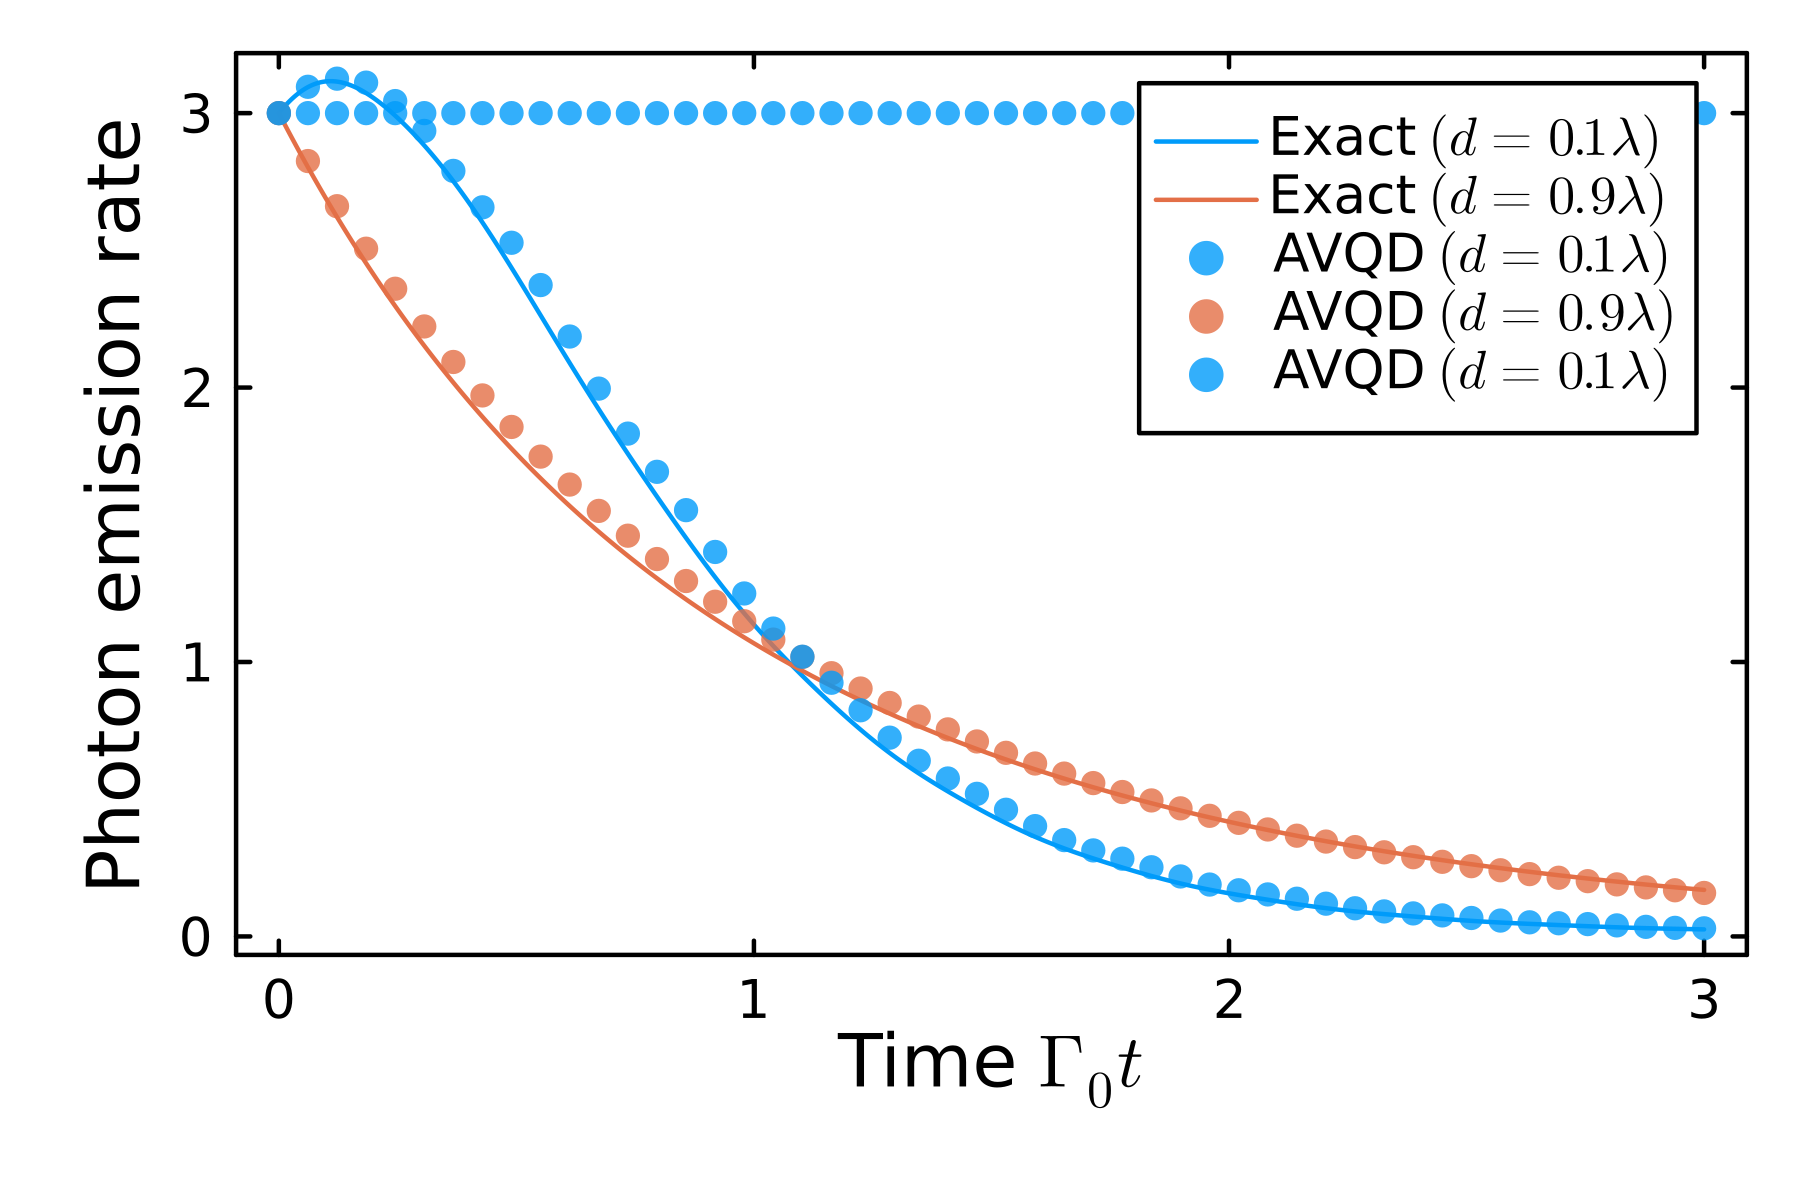

In [47]:
a = load("dicke_vectorized_0.1.jld2")
u_avqd = get(a, "u", "zero")
steps = 3000

N = 3

prop_emiss = zeros(Float64, steps)
prop_Pop_ee = zeros(Float64, steps)
for j in 1:steps
    prop_emiss[j] = real(tr(sum((Spin_obj.gamma_diag[i]) * (dagger(Spin_obj.J_diag[i]) * Spin_obj.J_diag[i]) for i = 1:N).data * u_avqd[j]))
    prop_Pop_ee[j] = real(tr(sum([spin_collection_op(Spin_obj, i)[2] * spin_collection_op(Spin_obj, i)[1] for i in 1:N]).data * u_avqd[j]))
end
avqd = [prop_emiss[i] for i in 1:steps]
times2 = LinRange(0, 3.0, 50)
avqd = avqd[1:60:end]
plot!(times2, avqd, seriestype=:scatter, mc=[1], ms=3, markershape=:circle, markerstrokewidth=0.0, ma=0.8, label=L"AVQD $( d = 0.1λ)$", linewidth=2)


In [48]:
a = load("dicke_vectorized_0.1.jld2")
u_avqd = get(a, "u", "zero")

a = load("dicke_vectorized_0.9.jld2")
u_avqd_long = get(a, "u", "zero")

a = load("dicke_exact_0.1.jld2")
u_exact = get(a, "u", "zero")

a = load("dicke_exact_0.9.jld2")
u_exact_long= get(a, "u", "zero")


steps = 3000

3000

In [54]:
N = 3

prop_emiss = zeros(Float64, steps)
prop_Pop_ee = zeros(Float64, steps)
for j in 1:steps
    prop_emiss[j] = real(tr(sum((Spin_obj.gamma_diag[i]) * (dagger(Spin_obj.J_diag[i]) * Spin_obj.J_diag[i]) for i = 1:N).data * u_avqd[j]))
    prop_Pop_ee[j] = real(tr(sum([spin_collection_op(Spin_obj, i)[2] * spin_collection_op(Spin_obj, i)[1] for i in 1:N]).data * u_avqd[j]))
end
avqd = [prop_emiss[i] for i in 1:steps]
times2 = LinRange(0, 3.0, 50)
avqd = avqd[1:60:end]

prop_emiss = zeros(Float64, steps)
prop_Pop_ee = zeros(Float64, steps)
for j in 1:steps
    prop_emiss[j] = real(tr(sum((Spin_obj.gamma_diag[i]) * (dagger(Spin_obj.J_diag[i]) * Spin_obj.J_diag[i]) for i = 1:N).data * u_avqd_long[j]))
    prop_Pop_ee[j] = real(tr(sum([spin_collection_op(Spin_obj, i)[2] * spin_collection_op(Spin_obj, i)[1] for i in 1:N]).data * u_avqd_long[j]))
end
avqd_long = [prop_emiss[i] for i in 1:steps]
times2 = LinRange(0, 3.0, 50)
avqd_long = avqd_long[1:60:end]

prop_emiss = zeros(Float64, steps)
prop_Pop_ee = zeros(Float64, steps)
for j in 1:steps
    prop_emiss[j] = real(tr(sum((Spin_obj.gamma_diag[i]) * (dagger(Spin_obj.J_diag[i]) * Spin_obj.J_diag[i]) for i = 1:N).data * u_exact[j]))
    prop_Pop_ee[j] = real(tr(sum([spin_collection_op(Spin_obj, i)[2] * spin_collection_op(Spin_obj, i)[1] for i in 1:N]).data * u_exact[j]))
end
exact = [prop_emiss[i] for i in 1:steps]
# avqd = avqd[1:60:end]

prop_emiss = zeros(Float64, steps)
prop_Pop_ee = zeros(Float64, steps)
for j in 1:steps
    prop_emiss[j] = real(tr(sum((Spin_obj.gamma_diag[i]) * (dagger(Spin_obj.J_diag[i]) * Spin_obj.J_diag[i]) for i = 1:N).data * u_exact_long[j]))
    prop_Pop_ee[j] = real(tr(sum([spin_collection_op(Spin_obj, i)[2] * spin_collection_op(Spin_obj, i)[1] for i in 1:N]).data * u_exact_long[j]))
end
exact_long = [prop_emiss[i] for i in 1:steps]
# avqd = avqd[1:60:end]



Plots.plot(times, exact, label=L"Exact $(d = 0.1λ)$", xlabel=L"Time $Γ_0t$", ylabel="Photon emission rate", linewidth=1, legend=:topright, grid=false, thickness_scaling=1.5, framestyle=:box)
plot!(times, exact_long, label=L"Exact $(d = 0.9λ)$", linewidth=1, legend=:topright)

plot!(times2, avqd, seriestype=:scatter, mc=[1], ms=3, markershape=:circle, markerstrokewidth=0.0, ma=0.8, label=L"UAVQD $( d = 0.1λ)$", linewidth=2)
plot!(times2, avqd_long, seriestype=:scatter, mc=[2], ms=3, markershape=:circle, markerstrokewidth=0.0, ma=0.8, label=L"UAVQD $( d = 0.9λ)$", linewidth=2)
plot!(dpi=300)
savefig("dicke_3chain.pdf")

┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:50.
└ @ Plots C:\Users\saura\.julia\packages\Plots\Pe7wF\src\utils.jl:141
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:50.
└ @ Plots C:\Users\saura\.julia\packages\Plots\Pe7wF\src\utils.jl:141
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:50.
└ @ Plots C:\Users\saura\.julia\packages\Plots\Pe7wF\src\utils.jl:141
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:50.
└ @ Plots C:\Users\saura\.julia\packages\Plots\Pe7wF\src\utils.jl:141


"c:\\Users\\saura\\OneDrive - purdue.edu\\Desktop\\dicke_3chain.pdf"